# **Ensembles**

### ***Importeren en inladen***

In [136]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier

In [137]:
df=pd.DataFrame()

In [138]:
data = pd.read_csv('data/train.csv')

In [139]:
data['stroke'].value_counts()

stroke
0    33033
1      517
Name: count, dtype: int64

### ***Data splitsen***

In [140]:
X = data.drop("stroke", axis=1)
y = data["stroke"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### ***Modellen trainen***

#### *RandomForest*
Random forest zijn allemaal decisiontrees bij elkaar. Deze decisiontrees maken gebruik van **bagging (bootstrap aggregation)** wat inhoud dat meerdere modellen onafhankelijk van elkaar getrained worden. Dit gebeurt wel op stukjes van de data, ook wel subsets genoemd. Bij elke splitsing worden er ook willekeurig features gekozen. Dit onafhankelijk trainen van elkaar geeft aan dat deze ensemble **parallel** is. Dit heeft als voordeel dat de trainingstijd een stuk lager is dan modellen die sequentieel trainen. Later in dit notebook komt sequentieel trainen nog aan bod.

Bij het trainen van modellen als random forest moet je vooraf bepaalde instellingen meegeven, dit zijn de hyperparameters. Deze moeten vooraf worden ingesteld, aangezien deze niet uit de data zelf worden geleerd. Deze parameters zorgen voor de manier hoe het model leert. Het proces van de beste waarden uitkiezen voor de hyperparameter heet hyperparameter tuning.

Wij hebben de **hyperparameter tuning** gedaan met GridSearchCV. Deze methode werkt eigenlijk heel simpel, aangezien dit alle combinaties van meegegeven waarden van de hyperparameters gaat proberen. Hierbij kiest best_estimator_ het best presterende model en best_params_ de bijbehorende hyperparameters met hun waarden.

RandomForestClassifier. (z.d.). Scikit-learn. https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestClassifier.html 

In [141]:
# Aanmaken van RandomForestClassifier, met class_weight='balanced' zorg je ervoor dat de fouten in de minderheidsklasse zwaarder meetellen
rf = RandomForestClassifier(class_weight='balanced')

# Hier wordt hyperparameter tuning toegepast
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [7, 8, 10],
    'min_samples_split': [5, 10, 12],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['sqrt', 'log2']
}

# Instellen en trainen van de gridsearch
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring='f1_macro', n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

# Bepalen van beste model en bijbehorende parameters met hun waarden en de beste score
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Printen van beste parameters met hun waarden
print("Beste hyperparameters voor RandomForest:", best_params)
print("Best score voor RandomForest:", best_score)

Beste hyperparameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Best score: 0.5427177455411016


In [158]:
# Hier wordt het model getraind (op de testset) met de beste parameters en wordt een f1_score berekend.
# Wij maken gebruik van average='macro', omdat hier alle klassen hetzelfde gewicht krijgen.
best_model_rf = RandomForestClassifier(class_weight='balanced', max_depth=10, max_features='log2', min_samples_leaf=2, n_estimators=50, min_samples_split=5)
best_model_rf.fit(X_train, y_train)
y_pred = best_model_rf.predict(X_test)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_macro

0.5310452437279427

## **Confusion Matrix**
Om meer inzicht te krijgen in de prestaties van het model hebben wij gebruik gemaakt van een confusion matrix. Je kunt de confusion matrix van je traindata vergelijken met die van je testdata, als deze allebei dicht bij elkaar zitten met bijvoorbeeld het aantal false positives betekent dit dat je model goed gefit is. Het is dan alleen nog de vraag of je blij bent met deze resultaten. Het is van te voren belangrijk om een beslissing te maken over wat je wilt optimaliseren.

Als je het aantal False Negatives (gemiste strokes) wilt minimaliseren moet je ervoor zorgen dat je model een hoge recall heeft.

Wil je het aantal False Positives (fout voorspelde strokes) wilt minimaliseren kies je voor het optimaliseren van de precision.

confusion_matrix. (z.d.). Scikit-learn. https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.confusion_matrix.html

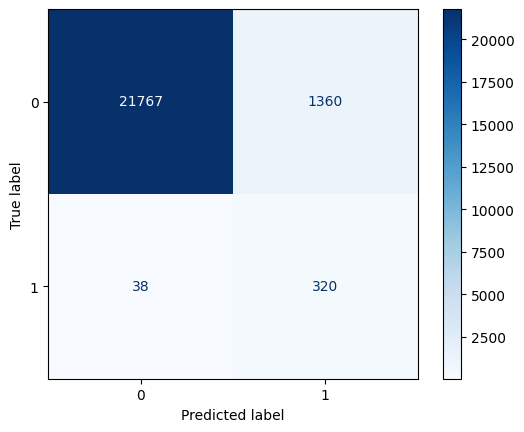

In [159]:
# Hier wordt een confusion matrix van de prestaties van het model op de trainset
y_pred = best_model.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

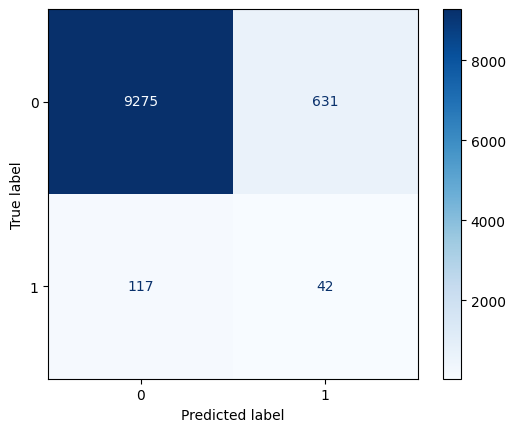

In [145]:
# Hier wordt een confusion matrix van de prestaties van het model op de testset
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

#### *GradientBoosting*
Bij gradient boosting wordt er ook gebruik gemaakt van het trainen van bomen alleen wordt deze d.m.v. boosting sequentieel getrainend. Boosting houdt in dat elke boom getrainend wordt op basis van de fouten die de vorige boom heeft gemaakt. Doordat boosting op deze manier werkt moet het model dus sequentieel trainen, omdat deze eerst moet wachten op de resultaten voor de vorige boom. Aangezien dit model dus niet tegelijk trained maar achter elkaar zorgt dit dus voor een tragere trainingstijd.

GradientBoostingClassifier. (z.d.). Scikit-learn. https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [149]:
# Aanmaken van GradientBoostingClassifier
gbdt = GradientBoostingClassifier()

# Hier wordt hyperparameter tuning toegepast
param_grid_gbdt = {
    'n_estimators': [150, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [8, 10, 12],
    'min_samples_leaf': [1, 2, 3]
}

# Instellen en trainen van de gridsearch
grid_search_gbdt = GridSearchCV(estimator=gbdt, param_grid=param_grid_gbdt, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_gbdt.fit(X_train, y_train)

# Bepalen van beste model en bijbehorende parameters met hun waarden en de beste score
best_params_gbdt = grid_search_gbdt.best_params_
best_gbdt_model = grid_search_gbdt.best_estimator_
best_gbdt_score = grid_search_gbdt.best_score_
print("Beste hyperparameters voor GBDT:", best_params_gbdt)
print("Beste score voor GBDT:", best_gbdt_score)

Beste hyperparameters voor GBDT: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}
Beste score voor GBDT: 0.5096257734683942


In [150]:
# Hier wordt het model getraind (op de testset) met de beste parameters en wordt een f1_score berekend.
# Wij maken gebruik van average='macro', omdat hier alle klassen hetzelfde gewicht krijgen.
best_model_gbdt = GradientBoostingClassifier(learning_rate=0.05, max_depth=5, min_samples_split=10, min_samples_leaf=2, n_estimators=200)
best_model_gbdt.fit(X_train, y_train)
y_pred = best_model_gbdt.predict(X_test)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_macro

0.5080891560230403

Confusion Matrix:
[[23011   116]
 [  123   235]]


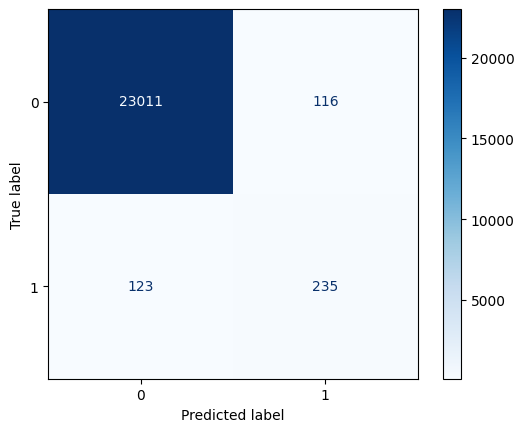

In [73]:
# Hier wordt een confusion matrix van de prestaties van het model op de trainset
y_pred = best_gbdt_model.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

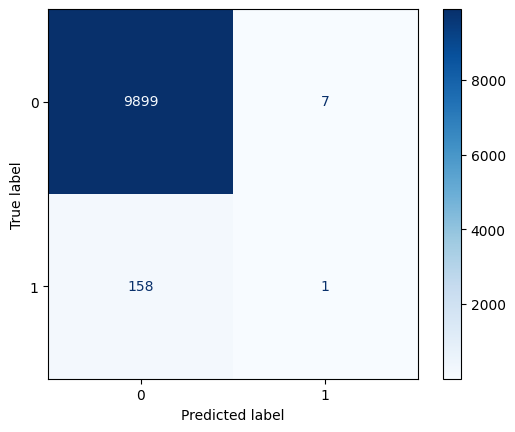

In [106]:
# Hier wordt een confusion matrix van de prestaties van het model op de testset
y_pred = best_gbdt_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

#### *XGBoosting*
XGBoosting, ook wel extreme gradient boosting, is simpelweg de geavanceerde versie van gradient boosting. Het heeft verschillende optimalisaties die ervoor zorgen dat het model sneller en efficienter werkt. Het model bevat regularisatie wat zorgt voor vermindering in overfitting. Ook net als bij gradient boosting worden de bomen in dit model sequentieel getrained, omdat de bomen de fouten van de vorige boom. De belangrijkste verschilen tussen XGBoosting en GradientBoosting zijn dus de extra hyperparameters en optimalisaties die ervoor zorgen dat het sneller werkt en overfitting vermindert.

GradientBoostingClassifier. (z.d.-b). Scikit-learn. https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [151]:
# Aanmaken van XGBoostClassifier
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

# Hier wordt hyperparameter tuning toegepast
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Instellen en trainen van de GridSearch
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train, y_train)

# Bepalen van beste model en bijbehorende parameters met hun waarden en de beste score
best_xgb_params = grid_search_xgb.best_params_
best_xgb_model = grid_search_xgb.best_estimator_
best_xgb_score = grid_search_xgb.best_score_
print("Beste hyperparameters voor XGB:", best_xgb_params)
print("Beste score voor XGB", best_xgb_score)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Beste hyperparameters voor XGB: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}
Beste score voor XGB 0.508568403279795


In [153]:
# Hier wordt het model getraind (op de testset) met de beste parameters en wordt een f1_score berekend.
# Wij maken gebruik van average='macro', omdat hier alle klassen hetzelfde gewicht krijgen.
best_model_xgb = XGBClassifier(learning_rate=0.2, max_depth=7, colsample_bytree=1.0, subsample=1.0, n_estimators=300)
best_model_xgb.fit(X_train, y_train)
y_pred = best_model_xgb.predict(X_test)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_macro

0.49564040889957905

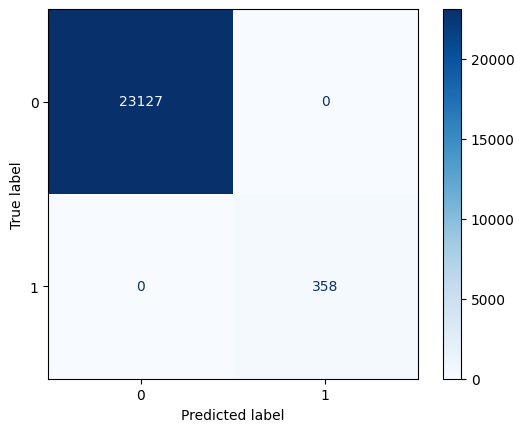

In [154]:
# Hier wordt een confusion matrix van de prestaties van het model op de trainset
y_pred = best_xgb_model.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

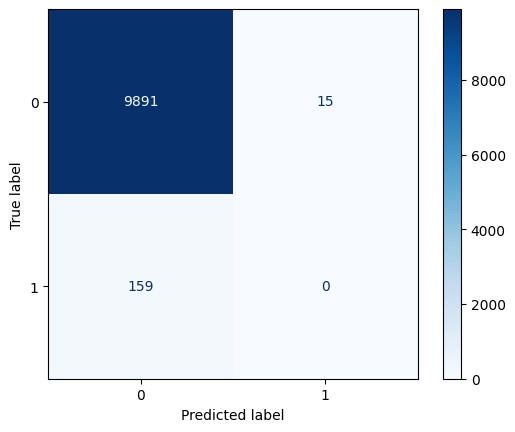

In [155]:
# Hier wordt een confusion matrix van de prestaties van het model op de testset
y_pred = best_xgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### ***Vergelijken van modellen***
Hier wordt van de ensembles een classification report gemaakt, om zo inzicht te krijgen in de resultaten van de modellen.

In [160]:
y_pred_rf = best_model.predict(X_test)
print("Random Forest:")
print(classification_report(y_test, y_pred_rf))

y_pred_gbdt = best_gbdt_model.predict(X_test)
print("Gradient Boosted Decision Trees:")
print(classification_report(y_test, y_pred_gbdt))

y_pred_xgb = best_xgb_model.predict(X_test)
print("XGBoost:")
print(classification_report(y_test, y_pred_xgb))

Random Forest:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      9906
           1       0.06      0.26      0.10       159

    accuracy                           0.93     10065
   macro avg       0.52      0.60      0.53     10065
weighted avg       0.97      0.93      0.95     10065

Gradient Boosted Decision Trees:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9906
           1       0.04      0.01      0.01       159

    accuracy                           0.98     10065
   macro avg       0.51      0.50      0.50     10065
weighted avg       0.97      0.98      0.98     10065

XGBoost:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9906
           1       0.00      0.00      0.00       159

    accuracy                           0.98     10065
   macro avg       0.49      0.50      0.50     10065
weighted avg     